In [1]:
import os
import glob
import json
import xml.etree.ElementTree as ET

import cv2
import pandas
import openslide
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import chain
import matplotlib.pyplot as plt

from pyslide import slide, patching, Stitching
from pyslide.util.utilities import mask2rgb
from pyslide.preprocessing import calculate_weights, calculate_std_mean

### Annotations

Parse annotation files in formats:
- qupath
- imageJ
- ASAP
- csv

In [4]:
qupath_path='data/annotations/qupath_annotations.json'
asap_path='data/annotations/asap_annotations.xml'
imagej_path='data/annotations/imagej_annotations.xml'
json_path='data/annotations/json_annotations.json'
#csv_path='data/annotations/csv_annotations.csv'

In [5]:
annotate_qupath=slide.Annotations([qupath_path],source="qupath")
annotate_imagej=slide.Annotations([imagej_path],source="imagej")
annotate_asap=slide.Annotations([asap_path],source="asap")
#annotate_csv=slide.Annotations([csv_path],source="csv")

In [6]:
annotate_qupath

    classes  number
0  Negative       4
1     Other       3

In [7]:
annotate_imagej

           classes  number
0                        1
1         FOLLICLE      29
2  GERMINAL CENTRE      27
3            SINUS      55
4          ADIPOSE       3

In [8]:
annotate_asap

      classes  number
0        None       1
1  metastases      20

class integer encoding

In [9]:
annotate_imagej.class_key

{'': 1, 'FOLLICLE': 2, 'GERMINAL CENTRE': 3, 'SINUS': 4, 'ADIPOSE': 5}

rename labels

In [10]:
annotate_imagej.rename_labels({'GERMINAL CENTRE':'GC'})
annotate_imagej.class_key

{'': 1, 'FOLLICLE': 2, 'SINUS': 3, 'ADIPOSE': 4, 'GC': 5}

Convert annotations to csv file or Pandas Dataframe

In [11]:
annotate_qupath.df()

,labels,x,y
0,Negative,73993,23888
1,Negative,73925,23895
2,Negative,73859,23914
3,Negative,73836,23926
4,Negative,73831,23928
...,...,...,...
139,Negative,74239,23889
140,Negative,74217,23888
141,Negative,73993,23888
142,Other,77875,23260


In [12]:
annotate_imagej.df()

,labels,x,y
0,,16527,9382
1,,65373,9382
2,,65373,30671
3,,16527,30671
4,FOLLICLE,20942,24654
...,...,...,...
1917,GC,37289,21330
1918,GC,37242,21330
1919,GC,37230,21330
1920,GC,37207,21330


In [13]:
annotate_qupath.save('annotation_coordinates.csv')

### Slide class

Pass wsi-path and annotation object to slide class. Following functions:
- Generate slide mask
- Crop a region
- Detect sections

In [14]:
QUPATH_PATH='/Users/w2030634/Projects/PySlide/data/annotations/qupath_example.json'
WSI_PATH='data/wsi/wsi.ndpi'

In [16]:
annotate=slide.Annotations([QUPATH_PATH],source="qupath",labels=['sinus','follicle','germinal centre'])
wsi=slide.Slide(WSI_PATH,mag=0,annotations=annotate)
mask=wsi.slide_mask
print('border:{}'.format(wsi.get_border()))

OpenSlideUnsupportedFormatError: Unsupported or missing image file

(-0.5, 1999.5, 1999.5, -0.5)

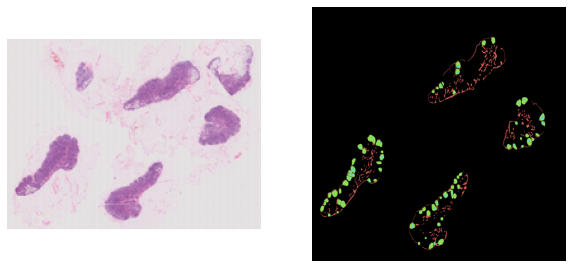

In [4]:
slide_thumbnail=np.array(wsi.get_thumbnail((200,200)))
mask=wsi.slide_mask
fig,axes=plt.subplots(1,2,figsize=(10,10))
axes[0].imshow(slide_thumbnail)
axes[0].axis('off')
axes[1].imshow(mask)
axes[1].axis('off')

#### Resize border 

In [12]:
print('border:{}'.format(wsi.get_border()))
borders=wsi.get_border()
x_new=wsi.resize_border(borders[0][0],factor=32)

border:[(3981.0, 118531.0), (11202.0, 92659.0)]


#### Detect components

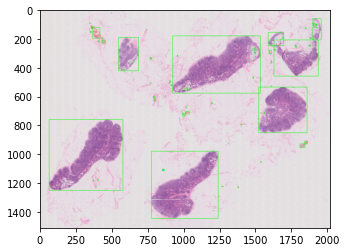

In [13]:
img,borders=wsi.detect_components()
plt.imshow(img[-1])

#### Generate region

extract regions

In [14]:
wsi.dimensions
border=borders[14]
(x1,x2),(y1,y2)=border
border

[(4032, 36864), (48576, 17152)]

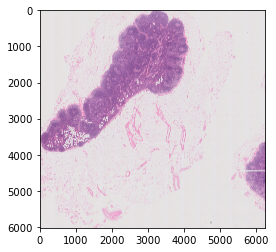

In [16]:
region=wsi.generate_region(mag=3,x=(x1,x2),y=(y1,y2),x_size=50000,y_size=50000)
plt.imshow(region[0])

### Patching Class

Split up WSI into a set of patches
- step size
- magnification
- size
- generate binary/multiclass masks (if annotations exist)
- generate patch labels (if annotations exist)

In [4]:
wsi.get_border()
patch=patching.Patching(wsi,mag_level=3,step=1024,size=(1024,1024))
patch.save('images',mask_flag=True)

num patches: 140


#### filter patches

Filter patches based on pixel intensity

Num removed: 106
Remaining:34


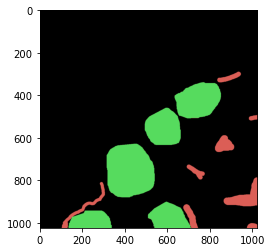

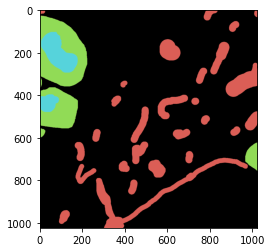

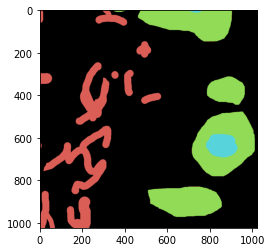

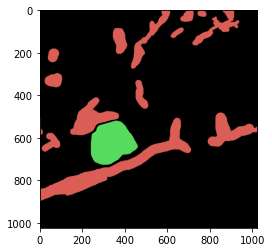

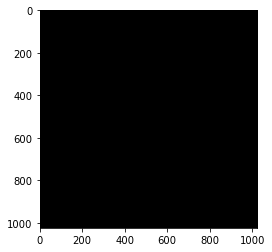

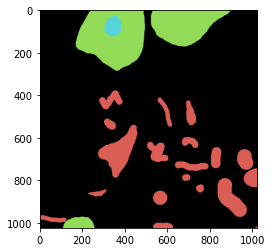

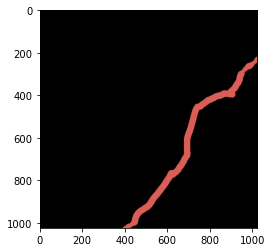

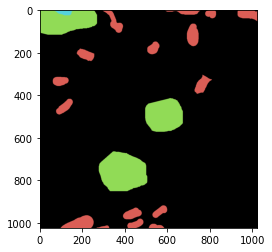

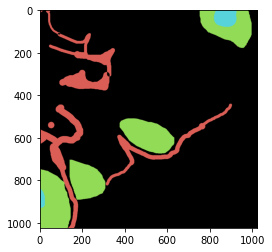

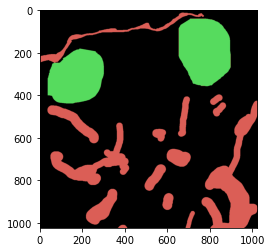

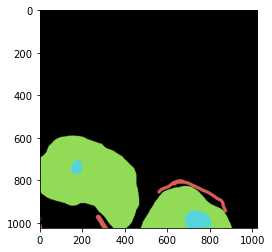

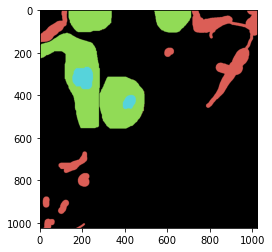

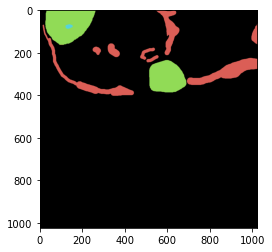

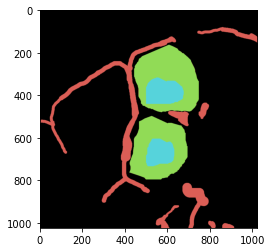

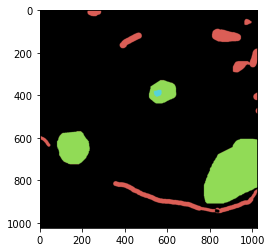

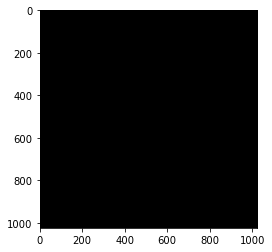

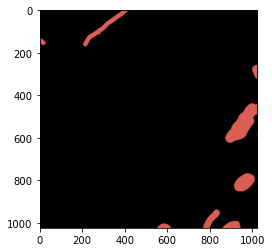

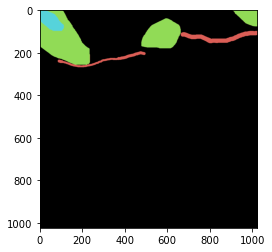

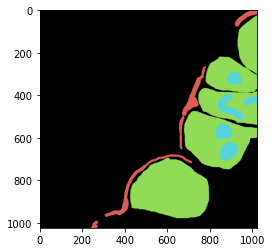

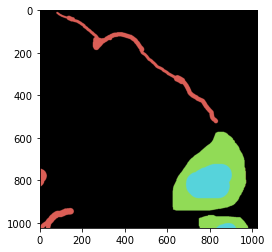

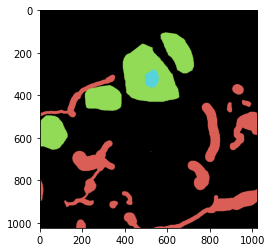

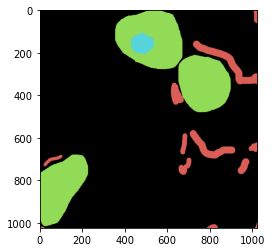

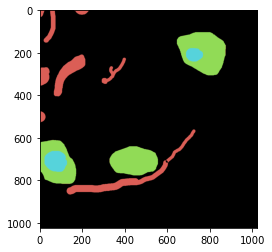

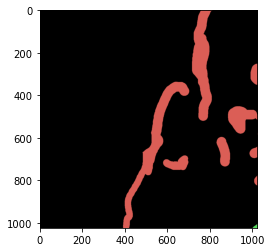

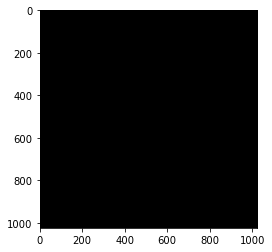

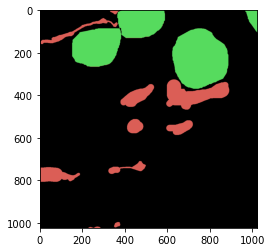

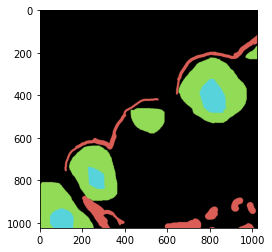

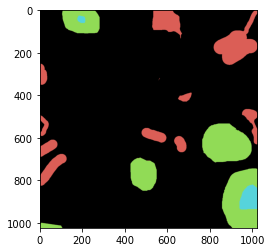

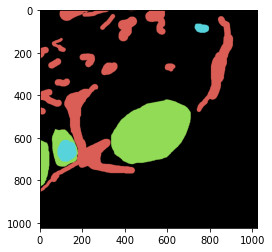

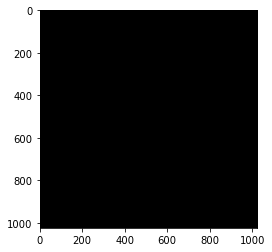

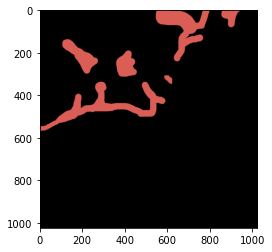

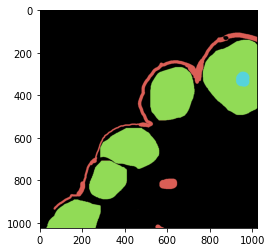

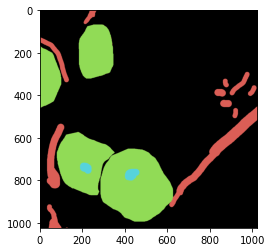

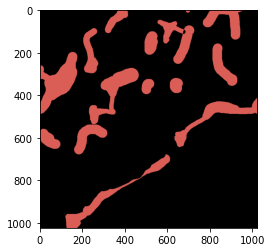

In [5]:
patch.filter_patches(210)
patch.save('images',mask_flag=True)
masks=glob.glob('images/masks/*')
for m in masks:
    mask=cv2.imread(m)
    mask=mask2rgb(mask[:,:,0])
    plt.imshow(mask)
    plt.show()

#### Get labels

Generate patch-level labels based on annotations. Threshold is used to filter patches where class doesn't reach given area of the patch. Where threshold isn't met assign to a new class.

(array(['0', '1', '2', 'below'], dtype='<U5'), array([ 4,  6, 13, 11]))


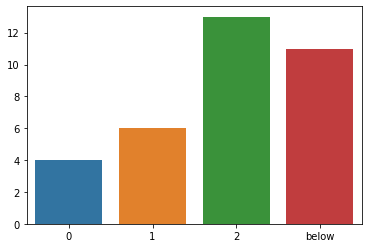

In [6]:
num=patch.generate_labels(0.6)
patch.plotlabeldist()
print(num)

### Stitching Class

Given a complete set of patches/masks (no filtering and a contiguous set of patch coordinates) we can stitch patches/masks back together into original image.

In [10]:
stitch=Stitching('images/images',name='2865 B2 LN.ndpi',mag_level=3)
canvas=stitch.stitch(size=(1024,1024))

{'name': '2865 B2 LN.ndpi', 'mag': 3, 'step': 1024, 'border': [[3981, 110477], [11202, 84930]], 'patches': 140}


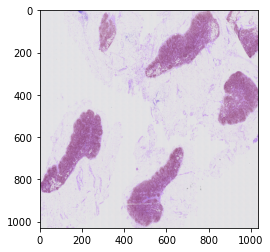

In [11]:
plt.imshow(canvas)

### Preprocessing Function

Calculate class imbalance and weights inversley proportional to area of each class

In [7]:
calculate_weights(mask_path='images/masks',num_cls=4)

[0.9618462698800223, 0.015078667231968471, 0.02121804782322475, 0.0018570150647844587]
[1.039667181039998, 66.31885859778691, 47.12968923113769, 538.4985932335819]


[1.039667181039998, 66.31885859778691, 47.12968923113769, 538.4985932335819]

In [9]:
calculate_std_mean('images/images')

total number pixels: 146800640
mean: [0.85010886 0.79945496 0.86400318], std: [0.09087634 0.16948016 0.10392946]


(array([0.85010886, 0.79945496, 0.86400318]),
 array([0.09087634, 0.16948016, 0.10392946]))